### Import libraries

In [34]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import numpy as np
from nltk.stem import PorterStemmer
import pandas as pd
import string
import re
from sklearn.feature_extraction.text import CountVectorizer
import time
import timeit
from ordered_set import OrderedSet
import multiprocessing.pool
import concurrent.futures



In [13]:
def get_and_clean_data():
    data = pd.read_csv('../Resource/software_developer_united_states_1971_20191023_1.csv')
    description = data['job_description']
    cleaned_description = description.apply(lambda s: s.translate(str.maketrans('', '', string.punctuation + u'\xa0')))
    cleaned_description = cleaned_description.apply(lambda s: s.lower())
    cleaned_description = cleaned_description.apply(lambda s: s.translate(str.maketrans(string.whitespace, ' ' * len(string.whitespace), '')))
    cleaned_description = cleaned_description.drop_duplicates()
    return cleaned_description
def simple_tokenize(data):
    cleaned_description = data.apply(lambda s: [x.strip() for x in s.split()])
    return cleaned_description

def parse_job_description():
    cleaned_description = get_and_clean_data()
    cleaned_description = simple_tokenize(cleaned_description)
    return cleaned_description


In [14]:

def setup_exp(exp_type, samples):
        cleaned_description = get_and_clean_data()[:samples]

        # replace non-alphabets with spaces, and collapse spaces
        cleaned_description = cleaned_description.apply(lambda s: re.sub(r'[^A-Za-z]', ' ', s))
        cleaned_description = cleaned_description.apply(lambda s: re.sub(r'\s+', ' ', s))

        # tokenize
        tokenized_description = cleaned_description.apply(lambda s: word_tokenize(s))

        # remove stop words
        if exp_type == "set":
            stop_dict = set(stopwords.words())
            sw_removed_description = tokenized_description.apply(lambda s: set(s) - stop_dict)
        elif exp_type == "list":
            stop_dict = list(stopwords.words())
            sw_removed_description = tokenized_description.apply(lambda s: [word for word in s if word not in stop_dict])
        sw_removed_description = sw_removed_description.apply(lambda s: [word for word in s if len(word) > 2])

        # create stem caches
        concated = np.unique(np.concatenate([s for s in tokenized_description.values]))
        stem_cache = {}
        ps = PorterStemmer()
        for s in concated:
            stem_cache[s] = ps.stem(s)

        # stem
        stemmed_description = sw_removed_description.apply(lambda s: [stem_cache[w] for w in s])

        # print(tokenized_description)
        cv = CountVectorizer(analyzer=lambda x: x)
        vectorizer = cv.fit(stemmed_description)
        X = vectorizer.transform(stemmed_description)
        # print(pd.DataFrame(X.toarray(), columns=cv.get_feature_names_out()))

In [15]:
set_exp = {}
list_exp = {}
for w in range(500, 3001, 500):
    print(w)
    set_exp[w] = timeit.timeit(lambda: setup_exp("set", w), number=1)
    list_exp[w] = timeit.timeit(lambda: setup_exp("list", w), number=1)

# Print the results
print("Set Experiment:", set_exp)
print("List Experiment:", list_exp)

500
1000
1500
2000
2500
3000
Set Experiment: {500: 5.920902662001026, 1000: 5.964224137998826, 1500: 7.113189359999524, 2000: 8.39660123000067, 2500: 9.905651255998237, 3000: 11.775882638001349}
List Experiment: {500: 21.699220456997864, 1000: 38.251295656002185, 1500: 55.76223509199917, 2000: 74.12125510999977, 2500: 97.88784235299681, 3000: 127.33087659999728}


In [16]:
pd.DataFrame.from_dict(set_exp, orient='index', columns=['Set Experiment'])

,Set Experiment
500,5.920903
1000,5.964224
1500,7.113189
2000,8.396601
2500,9.905651
3000,11.775883


In [17]:
pd.DataFrame.from_dict(list_exp, orient='index', columns=['Lits Experiment'])

,Lits Experiment
500,21.699220
1000,38.251296
1500,55.762235
2000,74.121255
2500,97.887842
3000,127.330877


Text(0, 0.5, 'Elapsed Time(s)')

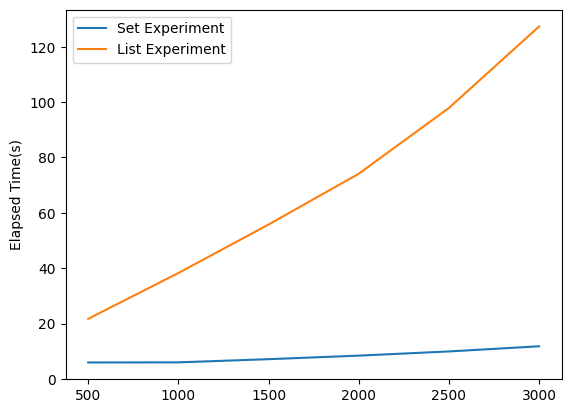

In [18]:
compare = pd.concat([pd.DataFrame.from_dict(set_exp, orient='index', columns=['Set Experiment']), pd.DataFrame.from_dict(list_exp, orient='index', columns=['List Experiment'])], axis=1)
p = compare.plot()
p.set_ylabel('Elapsed Time(s)')

Text(0, 0.5, 'times (x)')

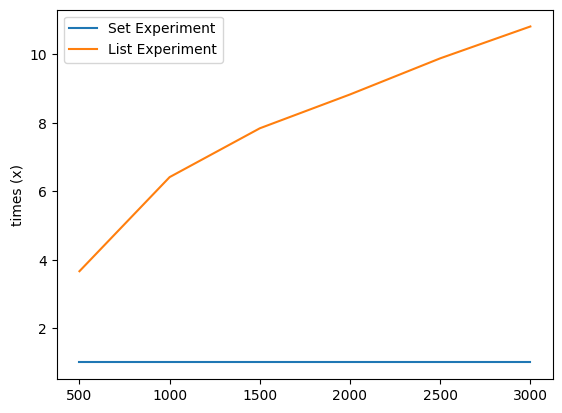

In [19]:
compare['List Experiment'] = compare['List Experiment'] / compare['Set Experiment']
compare['Set Experiment'] = 1
p = compare.plot()
p.set_ylabel('times (x)')

### Cores using set experiments

In [36]:
def core_exp(data):
    tokenized_description = data
    stop_dict = set(stopwords.words())
    sw_removed_description = tokenized_description.apply(lambda s: set(s) - stop_dict)
    sw_removed_description = sw_removed_description.apply(lambda s: [word for word in s if len(word) > 2])

    # create stem caches
    concated = np.unique(np.concatenate([s for s in tokenized_description.values]))
    stem_cache = {}
    ps = PorterStemmer()
    for s in concated:
        stem_cache[s] = ps.stem(s)

    # stem
    stemmed_description = sw_removed_description.apply(lambda s: [stem_cache[w] for w in s])

In [37]:
output = []
cores = [1, 2, 4, 6, 12]
parsed_description = parse_job_description()

for num_cpus in cores:
    print(num_cpus)
    start = time.time()
    parsed_description_split = np.array_split(parsed_description, num_cpus)
    with multiprocessing.pool.ThreadPool(processes=num_cpus) as pool:
        pool.map(core_exp, parsed_description_split)
    end = time.time()
    output.append(end-start)

print(output, cores)


1


/Users/CAMT/anaconda3/envs/SE-266/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


2
4
6
12
[22.721232891082764, 10.373474597930908, 8.038291931152344, 7.1352880001068115, 10.190836429595947] [1, 2, 4, 6, 12]


Text(0, 0.5, 'Time(s)')

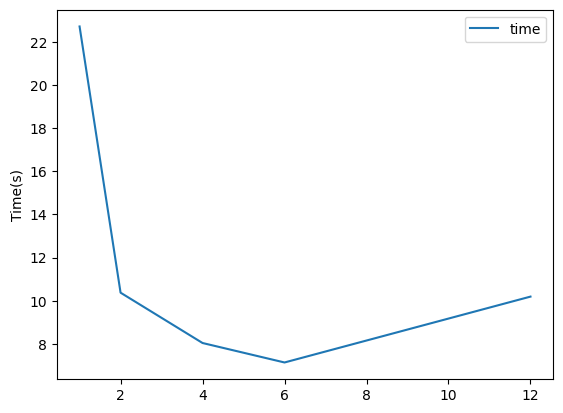

In [41]:
out_dict = {cores[n]: s for n, s in enumerate(output)}
p = pd.DataFrame.from_dict(out_dict, orient='index', columns=['time']).plot()
p.set_ylabel("Time(s)")

Text(0, 0.5, 'SpeedUp')

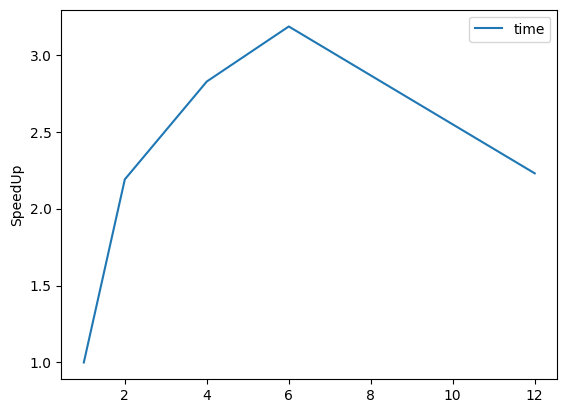

In [38]:
out_dict = {cores[n]: output[0]/s for n, s in enumerate(output)}
p = pd.DataFrame.from_dict(out_dict, orient='index', columns=['time']).plot()
p.set_ylabel("SpeedUp")